https://www.youtube.com/watch?v=Wqmtf9SA_kk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv("nybolig_data.csv")

In [ ]:
data

,url,address,postal_code,type,price,size,basement_size,rooms,year_built,year_renovated,energy_label
0,https://www.nybolig.dk/villa/7000/harevej/2300...,Harevej 3 7000 Fredericia,7000,villa,1695000,109,30,4,1952,1999,D
1,https://www.nybolig.dk/villa/9870/kirkevej/240...,Kirkevej 265 Tolne 9870 Sindal,9870,villa,375000,100,0,2,1925,None,F
2,https://www.nybolig.dk/raekkehus/8960/ledavej/...,Ledavej 12 8960 Randers SØ,8960,rækkehus,2198000,141,0,4,2008,None,B
3,https://www.nybolig.dk/villa/9900/olfertfische...,Olfert Fischers Vej 4 9900 Frederikshavn,9900,villa,895000,114,0,5,1960,1969,D
4,https://www.nybolig.dk/villa/8700/borgmesterve...,Borgmestervej 16 8700 Horsens,8700,villa,1195000,152,65,4,1933,1980,G
...,...,...,...,...,...,...,...,...,...,...,...
208,https://www.nybolig.dk/villa/8660/haraldsvej/1...,Haraldsvej 20 Gram 8660 Skanderborg,8660,villa,3795000,184,0,5,1976,1996,C
209,https://www.nybolig.dk/villa/8500/gjerrildbyga...,Gjerrild Bygade 44 Gjerrild 8500 Grenaa,8500,villa,898000,90,40,3,1959,None,G
210,https://www.nybolig.dk/ejerlejlighed/3480/park...,Parken 13 2. tv 3480 Fredensborg,3480,ejerlejlighed,1995000,65,None,3,1965,None,C
211,https://www.nybolig.dk/ejerlejlighed/2200/rant...,Rantzausgade 52 1. th 2200 København N,2200,ejerlejlighed,2750000,45,None,2,1889,2001,D


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             213 non-null    object
 1   address         213 non-null    object
 2   postal_code     213 non-null    int64 
 3   type            213 non-null    object
 4   price           213 non-null    int64 
 5   size            213 non-null    int64 
 6   basement_size   213 non-null    object
 7   rooms           213 non-null    int64 
 8   year_built      213 non-null    int64 
 9   year_renovated  213 non-null    object
 10  energy_label    213 non-null    object
dtypes: int64(5), object(6)
memory usage: 18.4+ KB


In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop(['price'], axis = 1)
y = data['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
train_data = X_train.join(y_train)

array([[<Axes: title={'center': 'postal_code'}>,
        <Axes: title={'center': 'size'}>],
       [<Axes: title={'center': 'rooms'}>,
        <Axes: title={'center': 'year_built'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >]], dtype=object)

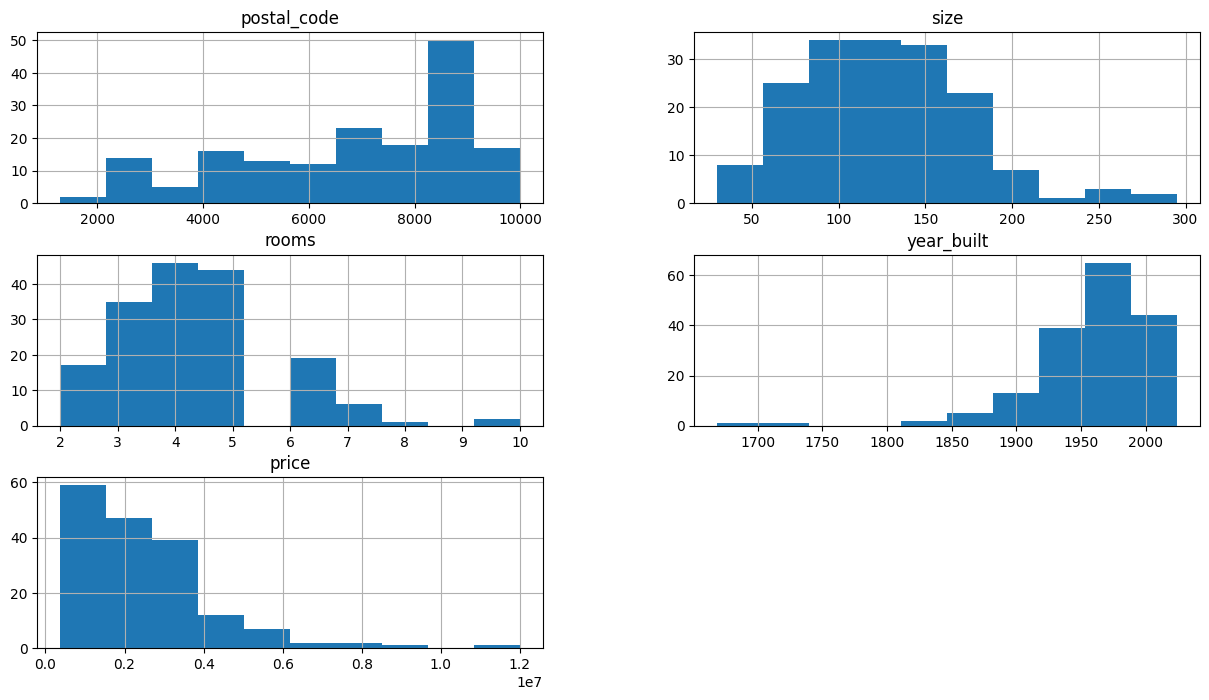

In [ ]:
train_data.hist(figsize = (15, 8))

<Axes: >

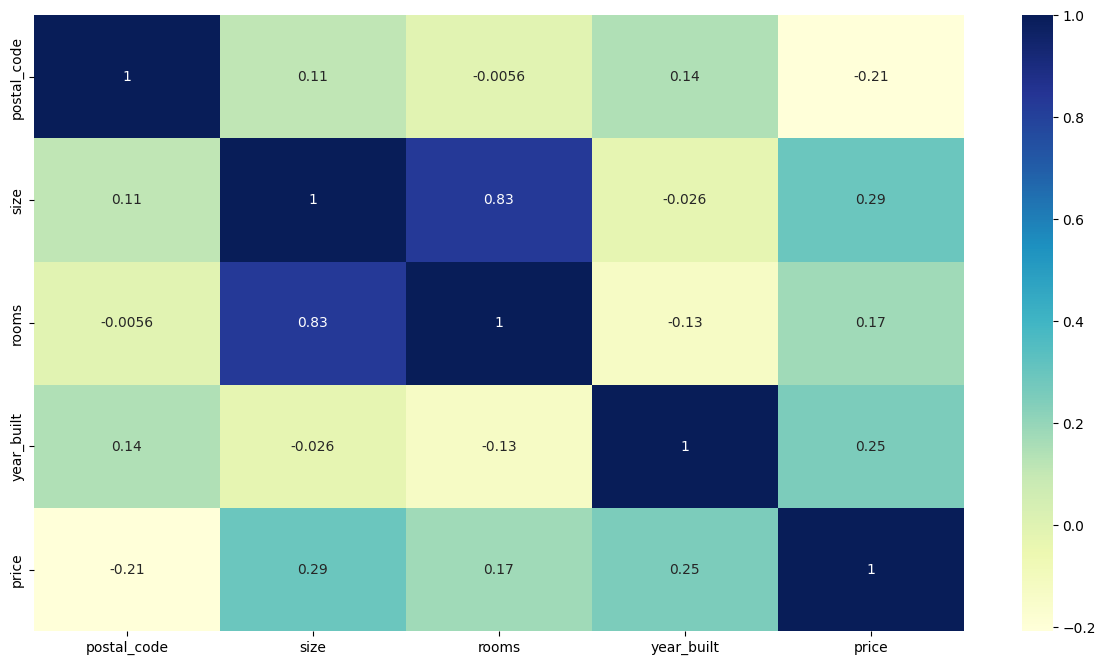

In [ ]:
plt.figure(figsize = (15, 8))
# sns.heatmap(train_data.corr(), annot = True, cmap = "YlGnBu")
# Do heatmap of correlation only on the numerical data
sns.heatmap(train_data.select_dtypes(include = np.number).corr(), annot = True, cmap = "YlGnBu")

In [ ]:
# Skew of the data
train_data.select_dtypes(include = np.number).skew()

postal_code   -0.656426
size           0.614336
rooms          0.771744
year_built    -1.953123
price          1.856447
dtype: float64

array([[<Axes: title={'center': 'original'}>,
        <Axes: title={'center': 'sqrt'}>,
        <Axes: title={'center': 'log'}>],
       [<Axes: title={'center': 'boxcox'}>,
        <Axes: title={'center': 'exp'}>,
        <Axes: title={'center': 'reciprocal'}>],
       [<Axes: title={'center': 'log_on_reciprocal'}>, <Axes: >,
        <Axes: >]], dtype=object)

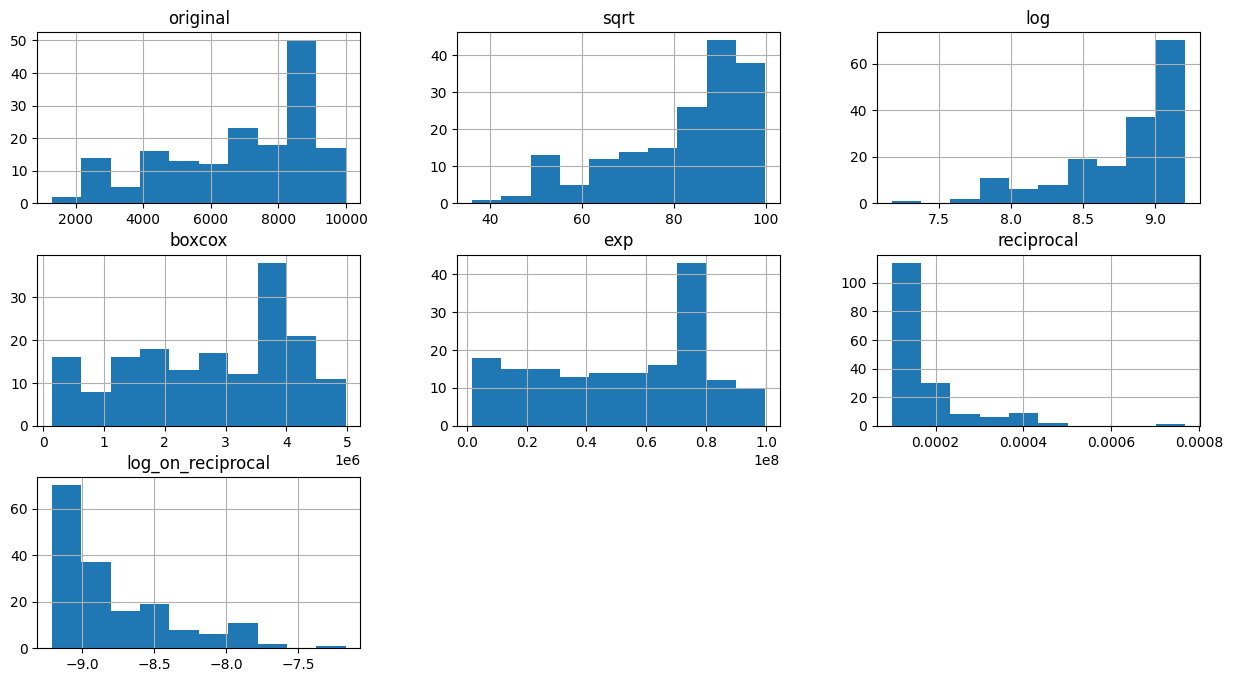

In [ ]:
from scipy.stats import boxcox
# Testing different transformations of the postal_code
transformed_test = pd.DataFrame()
transformed_test['original'] = train_data['postal_code']
transformed_test['sqrt'] = np.sqrt(train_data['postal_code'])
transformed_test['log'] = np.log(train_data['postal_code'])
transformed_test['boxcox'], _ = boxcox(train_data['postal_code'])
transformed_test['exp'] = (train_data['postal_code']) ** 2
transformed_test['reciprocal'] = 1 / (train_data['postal_code'])
transformed_test['log_on_reciprocal'] = np.log(1 / (train_data['postal_code']))

transformed_test.hist(figsize = (15, 8))

In [ ]:
# Skew of the different transformations
transformed_test.skew()

original            -0.656426
sqrt                -0.942171
log                 -1.320253
boxcox              -0.333932
exp                 -0.235967
reciprocal           2.707337
log_on_reciprocal    1.320253
dtype: float64

array([[<Axes: title={'center': 'postal_code'}>,
        <Axes: title={'center': 'size'}>],
       [<Axes: title={'center': 'rooms'}>,
        <Axes: title={'center': 'year_built'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >]], dtype=object)

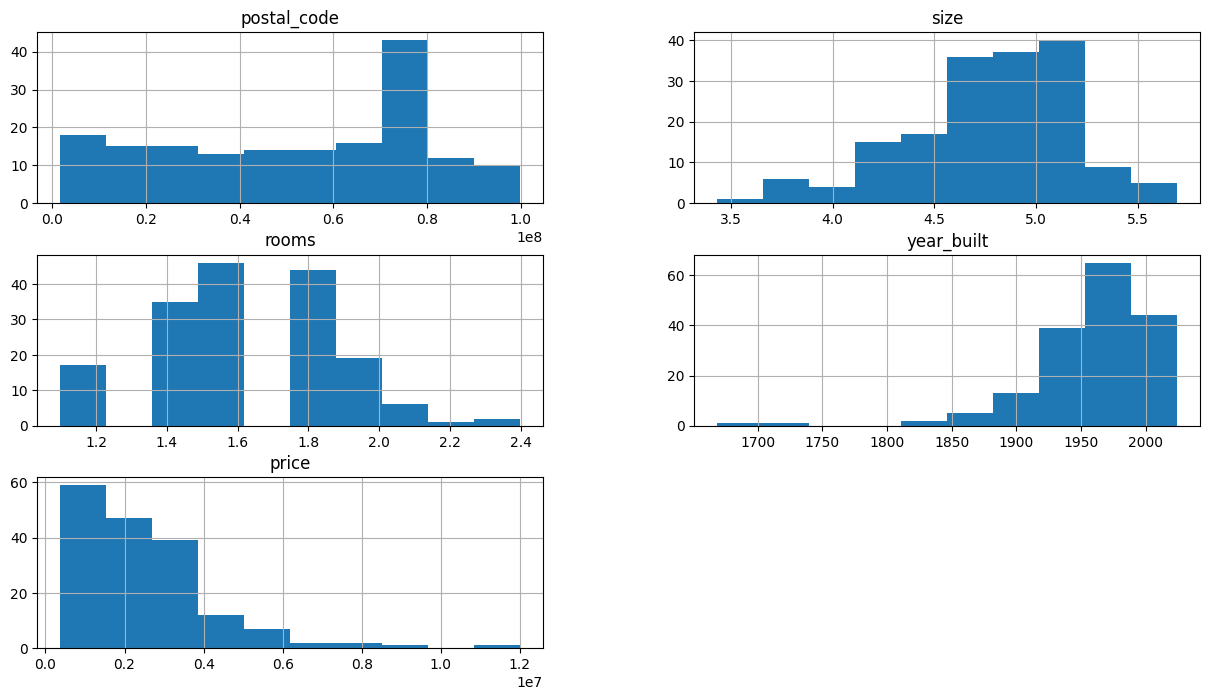

In [ ]:
train_data['postal_code'] = (train_data['postal_code'] + 1) ** 2
train_data['rooms'] = np.log(train_data['rooms'] + 1)
train_data['size'] = np.log(train_data['size'] + 1)
train_data.hist(figsize = (15, 8))

In [ ]:
train_data.type.value_counts()

villa             104
ejerlejlighed      29
rækkehus           17
fritidsbolig       17
andelsbolig         2
villalejlighed      1
Name: type, dtype: int64

# Lasso Regression 

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

#Create the model 
clf = linear_model.Lasso(alpha = 0.1)

#Fit the Model
clf.fit(X_train, y_train)

#Predict on the test data
y_pred = clf.predict(X_test)



ImportError: cannot import name 'linear_models' from 'sklearn' (/usr/local/lib/python3.10/site-packages/sklearn/__init__.py)